In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [3]:
from PIL import Image
import os
import os.path
import numpy as np
import pickle
import sys

import torch.utils.data as data

class CIFAR100TL(data.Dataset):
    #base_folder = 'class1'
    train_list = [
        ['train'],
    ]

    test_list = [
        ['test'],
    ]

    def __init__(self, root,subset,train=True,
                 transform=None, target_transform=None,
                 download=False):
        self.root = os.path.expanduser(root)
        self.transform = transform
        self.target_transform = target_transform
        self.train = train  # training set or test set
        self.subset = subset
        if self.train:
            downloaded_list = self.train_list
        else:
            downloaded_list = self.test_list

        self.data = []
        self.targets = []

        # now load the picked numpy arrays
        for file_name in downloaded_list:
            file_path = os.path.join(self.root, self.subset, file_name[0])
            with open(file_path, 'rb') as f:
                if sys.version_info[0] == 2:
                    entry = pickle.load(f)
                else:
                    entry = pickle.load(f, encoding='latin1')
                print(entry.keys())
                self.data.append(entry['data'])
                self.targets.extend(entry['fine_labels'])

        self.data = np.vstack(self.data).reshape(-1, 3, 32, 32)
        self.data = self.data.transpose((0, 2, 3, 1))  

    def __getitem__(self, index):
        img, target = np.array(self.data[index], dtype='uint8'), np.array(self.targets[index], dtype='float')
        #print(type(img))
        #img = img.astype(int8) 
        #print(img.dtype)
        #print(img)
        img = Image.fromarray(img)
        #print(type(img))
        #print(target)

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self):
        return len(self.data)

    def __repr__(self):
        fmt_str = 'Dataset ' + self.__class__.__name__ + '\n'
        fmt_str += '    Number of datapoints: {}\n'.format(self.__len__())
        tmp = 'train' if self.train is True else 'test'
        fmt_str += '    Split: {}\n'.format(tmp)
        fmt_str += '    Root Location: {}\n'.format(self.root)
        tmp = '    Transforms (if any): '
        fmt_str += '{0}{1}\n'.format(tmp, self.transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        tmp = '    Target Transforms (if any): '
        fmt_str += '{0}{1}'.format(tmp, self.target_transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        return fmt_str

In [4]:
USE_GPU = True

dtype = torch.uint8 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cuda


In [5]:
def check_accuracy(loader, model,Accuracy_list):
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:            
            x = x.to(device=device, dtype=torch.float32)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
        Accuracy_list.append(100*acc)

In [6]:
def test_accuracy(loader, model):
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            
            x = x.to(device=device, dtype=torch.float32)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
        #Accuracy_list.append(100*acc)

In [7]:
def train_process(model, optimizer, epochs, rounds,scale,Loss_list,Accuracy_list):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    best_model = model
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    print("====> rounds: "+ str(rounds))
    for e in range(epochs):
        print("Epoch====>%d" % e)
        for t, (x, y) in enumerate(loader_train):
            #print(x.shape)
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=torch.float32)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            
            scores = model(x)
            loss = F.cross_entropy(scores, y) * scale

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

            if t % print_every == 0:
                Loss_list.append(loss.item())
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                check_accuracy(cifar100_valid, model,Accuracy_list)

In [16]:
class NetCC(nn.Module):
    def __init__(self):
        super(NetCC, self).__init__()
        self.conv1 = nn.Conv2d(3, 96, 3,stride=1,padding=1)
        self.pool = nn.MaxPool2d(3, 2)
        self.conv2 = nn.Conv2d(96, 96, 3,stride=1,padding=1)
        self.conv3 = nn.Conv2d(96,96,3,stride=2,padding=1)
        self.conv4 = nn.Conv2d(96,192,3,stride=1,padding=1)
        self.conv5 = nn.Conv2d(192,192,3,stride=1,padding=1)
        self.conv6 = nn.Conv2d(192,192,3,stride=2,padding=1)
        self.conv7 = nn.Conv2d(192,192,3,stride=1,padding=1)
        self.conv8 = nn.Conv2d(192,192,1)
        self.conv9 = nn.Conv2d(192,10,1)
        self.grouppool = nn.AvgPool2d(6,6)
        #self.fc1 = nn.Linear(40,10)
    def forward(self, x):
        x = F.dropout2d(F.relu(self.conv1(x)))
        x = F.dropout2d(F.relu(self.conv2(x)))
        x = F.dropout2d(F.relu(self.conv3(x)))
        x = F.dropout2d(F.relu(self.conv4(x)))
        x = F.dropout2d(F.relu(self.conv5(x)))
        x = F.dropout2d(F.relu(self.conv6(x)))
        x = F.dropout2d(F.relu(self.conv7(x)))
        x = F.dropout2d(F.relu(self.conv8(x)))
        x = F.dropout2d(F.relu(self.conv9(x)))
        x = self.grouppool(x)
        x = x.view(x.shape[0],-1)
        #x = F.softmax(x)
        #print(x.shape)
        #x = self.fc1(x)
        return x


In [7]:
transform = T.Compose([
                T.ToTensor(),
                T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ])
cifar100_train = CIFAR100TL('./datasets',train=True,subset='class1',transform=transform)
loader_train = torch.utils.data.DataLoader(cifar100_train, batch_size=64)
NUM_TRAIN = len(cifar100_train)
print(NUM_TRAIN)
cifar100_valid = torch.utils.data.DataLoader(cifar100_train,batch_size=64,sampler=sampler.SubsetRandomSampler(range(4000, 5000)))

cifar100_test = CIFAR100TL('./datasets',train=False,subset='class1',transform=transform)
loader_test = torch.utils.data.DataLoader(cifar100_test,batch_size=1)
print(len(cifar100_test))

dict_keys(['filenames', 'batch_label', 'fine_labels', 'data', 'fine_label_names'])
5000
dict_keys(['filenames', 'batch_label', 'fine_labels', 'data', 'fine_label_names'])
1000


In [18]:
from torch.nn import init
modelCC = torch.load('./new_models/modelCC_1.pkl')

model_weights = []
savew1 = (modelCC.conv1.weight)
savew2 = (modelCC.conv2.weight)
savew3 = (modelCC.conv3.weight)
savew4 = (modelCC.conv4.weight)
savew5 = (modelCC.conv5.weight)
savew6 = (modelCC.conv6.weight)
savew7 = (modelCC.conv7.weight)
savew8 = (modelCC.conv8.weight)
saveb1 = (modelCC.conv1.bias)
saveb1 = (modelCC.conv2.bias)
saveb1 = (modelCC.conv3.bias)
saveb1 = (modelCC.conv4.bias)
saveb1 = (modelCC.conv5.bias)
saveb1 = (modelCC.conv6.bias)
saveb1 = (modelCC.conv7.bias)
saveb1 = (modelCC.conv8.bias)
test_accuracy(loader_test,modelCC)

# init.xavier_uniform_(modelCC.conv9.weight)
# init.constant_(modelCC.conv9.bias, 0.1)

# modelCC.conv9 = nn.Conv2d(192,10,1).cuda()
test_accuracy(loader_test,modelCC)

Checking accuracy on test set
Got 64 / 1000 correct (6.40)
Checking accuracy on test set
Got 126 / 1000 correct (12.60)


In [21]:
Loss_list = []
Accuracy_list = []
learning_rate = 0.0005
decay = 0.8
best_model = None
top_acc = None

for i in range(20):
    if i%5==1:
        learning_rate = learning_rate*decay
    optimizer = optim.SGD(modelCC.parameters(), lr=learning_rate,
                     momentum=0.9, nesterov=True,weight_decay=0.01)
    train_process(modelCC,optimizer,epochs=1,rounds=i,scale=2.0,Loss_list=Loss_list,Accuracy_list=Accuracy_list)
torch.save(modelCC,'./test/modelCC_tf_test.pkl')

====> rounds: 0
Epoch====>0
Iteration 0, loss = 5.4507
Checking accuracy on validation set
Got 120 / 1000 correct (12.00)
====> rounds: 1
Epoch====>0
Iteration 0, loss = 3.4630
Checking accuracy on validation set
Got 477 / 1000 correct (47.70)
====> rounds: 2
Epoch====>0
Iteration 0, loss = 3.0767
Checking accuracy on validation set
Got 561 / 1000 correct (56.10)
====> rounds: 3
Epoch====>0
Iteration 0, loss = 2.8094
Checking accuracy on validation set
Got 611 / 1000 correct (61.10)
====> rounds: 4
Epoch====>0
Iteration 0, loss = 2.6229
Checking accuracy on validation set
Got 633 / 1000 correct (63.30)
====> rounds: 5
Epoch====>0
Iteration 0, loss = 2.5036
Checking accuracy on validation set
Got 643 / 1000 correct (64.30)
====> rounds: 6
Epoch====>0
Iteration 0, loss = 2.3989
Checking accuracy on validation set
Got 640 / 1000 correct (64.00)
====> rounds: 7
Epoch====>0
Iteration 0, loss = 2.2218
Checking accuracy on validation set
Got 663 / 1000 correct (66.30)
====> rounds: 8
Epoch===

/root/Anaconda/anaconda3/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type NetCC. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


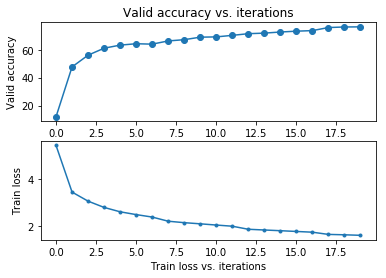

In [22]:
x1 = range(0, len(Accuracy_list)) # 8*10*6
x2 = range(0, len(Loss_list))
y1 = Accuracy_list
y2 = Loss_list
plt.subplot(2, 1, 1)
plt.plot(x1, y1, 'o-')
plt.title('Valid accuracy vs. iterations')
plt.ylabel('Valid accuracy')
plt.subplot(2, 1, 2)
plt.plot(x2, y2, '.-')
plt.xlabel('Train loss vs. iterations')
plt.ylabel('Train loss')
plt.show()

In [23]:
test_accuracy(loader_test,modelCC)

Checking accuracy on test set
Got 664 / 1000 correct (66.40)


In [25]:
# class 2
transform = T.Compose([
                T.ToTensor(),
                T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ])
cifar100_train = CIFAR100TL('./datasets',train=True,subset='class2',transform=transform)
loader_train = torch.utils.data.DataLoader(cifar100_train, batch_size=64)
NUM_TRAIN = len(cifar100_train)
print(NUM_TRAIN)
cifar100_valid = torch.utils.data.DataLoader(cifar100_train,batch_size=64,sampler=sampler.SubsetRandomSampler(range(4000, 5000)))

cifar100_test = CIFAR100TL('./datasets',train=False,subset='class2',transform=transform)
loader_test = torch.utils.data.DataLoader(cifar100_test,batch_size=50)
print(len(cifar100_test))

dict_keys(['filenames', 'batch_label', 'fine_labels', 'data', 'fine_label_names'])
5000
dict_keys(['filenames', 'batch_label', 'fine_labels', 'data', 'fine_label_names'])
1000


In [24]:
from torch.nn import init
modelCC = torch.load('./new_models/modelCC_1.pkl')


test_accuracy(loader_test,modelCC)

# init.xavier_uniform_(modelCC.conv9.weight)
# init.constant_(modelCC.conv9.bias, 0.1)
modelCC.conv9 = nn.Conv2d(192,10,1).cuda()
test_accuracy(loader_test,modelCC)

Checking accuracy on test set
Got 64 / 1000 correct (6.40)
Checking accuracy on test set
Got 76 / 1000 correct (7.60)


In [26]:
Loss_list = []
Accuracy_list = []
learning_rate = 0.0005
decay = 0.8
for i in range(20):
    if i%5==1:
        learning_rate = learning_rate*decay
    optimizer = optim.SGD(modelCC.parameters(), lr=learning_rate,
                     momentum=0.9, nesterov=True,weight_decay=0.001)
    train_process(modelCC,optimizer,epochs=1,rounds=i,scale=2.0,Loss_list=Loss_list,Accuracy_list=Accuracy_list)
torch.save(modelCC,'./test/modelCC_tf2.pkl')

====> rounds: 0
Epoch====>0
Iteration 0, loss = 5.3264
Checking accuracy on validation set
Got 87 / 1000 correct (8.70)
====> rounds: 1
Epoch====>0
Iteration 0, loss = 3.7333
Checking accuracy on validation set
Got 469 / 1000 correct (46.90)
====> rounds: 2
Epoch====>0
Iteration 0, loss = 3.2619
Checking accuracy on validation set
Got 553 / 1000 correct (55.30)
====> rounds: 3
Epoch====>0
Iteration 0, loss = 3.0382
Checking accuracy on validation set
Got 576 / 1000 correct (57.60)
====> rounds: 4
Epoch====>0
Iteration 0, loss = 2.9871
Checking accuracy on validation set
Got 589 / 1000 correct (58.90)
====> rounds: 5
Epoch====>0
Iteration 0, loss = 2.8876
Checking accuracy on validation set
Got 604 / 1000 correct (60.40)
====> rounds: 6
Epoch====>0
Iteration 0, loss = 2.8134
Checking accuracy on validation set
Got 608 / 1000 correct (60.80)
====> rounds: 7
Epoch====>0
Iteration 0, loss = 2.4311
Checking accuracy on validation set
Got 633 / 1000 correct (63.30)
====> rounds: 8
Epoch====>

/root/Anaconda/anaconda3/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type NetCC. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


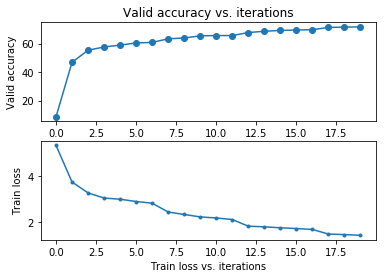

In [27]:
x1 = range(0, len(Accuracy_list)) # 8*10*6
x2 = range(0, len(Loss_list))
y1 = Accuracy_list
y2 = Loss_list
plt.subplot(2, 1, 1)
plt.plot(x1, y1, 'o-')
plt.title('Valid accuracy vs. iterations')
plt.ylabel('Valid accuracy')
plt.subplot(2, 1, 2)
plt.plot(x2, y2, '.-')
plt.xlabel('Train loss vs. iterations')
plt.ylabel('Train loss')
plt.show()

In [28]:
test_accuracy(loader_test,modelCC)

Checking accuracy on test set
Got 650 / 1000 correct (65.00)


In [9]:
# class 2 bonus
transform = T.Compose([
                T.ToTensor(),
                T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ])
cifar100_train = CIFAR100TL('./datasets',train=True,subset='class2',transform=transform)
loader_train = torch.utils.data.DataLoader(cifar100_train, batch_size=64)
NUM_TRAIN = len(cifar100_train)
print(NUM_TRAIN)
cifar100_valid = torch.utils.data.DataLoader(cifar100_train,batch_size=64,sampler=sampler.SubsetRandomSampler(range(4000, 5000)))

cifar100_test = CIFAR100TL('./datasets',train=False,subset='class2',transform=transform)
loader_test = torch.utils.data.DataLoader(cifar100_test,batch_size=50)
print(len(cifar100_test))

dict_keys(['filenames', 'batch_label', 'fine_labels', 'data', 'fine_label_names'])
5000
dict_keys(['filenames', 'batch_label', 'fine_labels', 'data', 'fine_label_names'])
1000


In [17]:
from torch.nn import init
modelCC = torch.load('./new_models/modelCC_1.pkl')


test_accuracy(loader_test,modelCC)

# init.xavier_uniform_(modelCC.conv9.weight)
# init.constant_(modelCC.conv9.bias, 0.1)
modelCC.conv1 = nn.Conv2d(3, 96, 3,stride=1,padding=1).cuda()
modelCC.conv9 = nn.Conv2d(192,10,1).cuda()
test_accuracy(loader_test,modelCC)

Checking accuracy on test set
Got 78 / 1000 correct (7.80)
Checking accuracy on test set
Got 90 / 1000 correct (9.00)


In [18]:
Loss_list = []
Accuracy_list = []
learning_rate = 0.0005
decay = 0.8
for i in range(30):
    if i%5==1:
        learning_rate = learning_rate*decay
    optimizer = optim.SGD(modelCC.parameters(), lr=learning_rate,
                     momentum=0.9, nesterov=True,weight_decay=0.001)
    train_process(modelCC,optimizer,epochs=1,rounds=i,scale=2.0,Loss_list=Loss_list,Accuracy_list=Accuracy_list)
torch.save(modelCC,'./test/modelCC_tf3.pkl')

====> rounds: 0
Epoch====>0
Iteration 0, loss = 4.7286
Checking accuracy on validation set
Got 103 / 1000 correct (10.30)
====> rounds: 1
Epoch====>0
Iteration 0, loss = 3.9925
Checking accuracy on validation set
Got 340 / 1000 correct (34.00)
====> rounds: 2
Epoch====>0
Iteration 0, loss = 3.6858
Checking accuracy on validation set
Got 407 / 1000 correct (40.70)
====> rounds: 3
Epoch====>0
Iteration 0, loss = 3.5231
Checking accuracy on validation set
Got 450 / 1000 correct (45.00)
====> rounds: 4
Epoch====>0
Iteration 0, loss = 3.5753
Checking accuracy on validation set
Got 494 / 1000 correct (49.40)
====> rounds: 5
Epoch====>0
Iteration 0, loss = 3.5526
Checking accuracy on validation set
Got 513 / 1000 correct (51.30)
====> rounds: 6
Epoch====>0
Iteration 0, loss = 3.4981
Checking accuracy on validation set
Got 527 / 1000 correct (52.70)
====> rounds: 7
Epoch====>0
Iteration 0, loss = 3.2926
Checking accuracy on validation set
Got 545 / 1000 correct (54.50)
====> rounds: 8
Epoch===

/root/Anaconda/anaconda3/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type NetCC. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


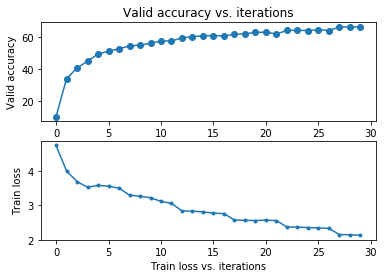

In [21]:
x1 = range(0, len(Accuracy_list)) # 8*10*6
x2 = range(0, len(Loss_list))
y1 = Accuracy_list
y2 = Loss_list
plt.subplot(2, 1, 1)
plt.plot(x1, y1, 'o-')
plt.title('Valid accuracy vs. iterations')
plt.ylabel('Valid accuracy')
plt.subplot(2, 1, 2)
plt.plot(x2, y2, '.-')
plt.xlabel('Train loss vs. iterations')
plt.ylabel('Train loss')
plt.show()

In [22]:
test_accuracy(loader_test,modelCC)

Checking accuracy on test set
Got 583 / 1000 correct (58.30)
